In [52]:
# import package
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [8]:
# I'm limited by RAM here and taking the first N rows is likely to be
# a bad idea for the date data since it is ordered.
# Sample the data in a roundabout way:
date_chunks = pd.read_csv("../data/train_date.csv", index_col=0, chunksize=10000, dtype=np.float32)
num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=10000, dtype=np.float32)
df_train = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
y = pd.read_csv("../data/train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[df_train.index].values.ravel()
X = df_train.values

In [9]:
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [10]:
fea_importance = pd.DataFrame(clf.feature_importances_)

In [13]:
fea_importance.index = df_train.columns

In [22]:
fea_importance.columns=["feature_importance"]

In [23]:
fea_importance_new = fea_importance[fea_importance.feature_importance >0.005]

<IPython.core.display.Javascript object>


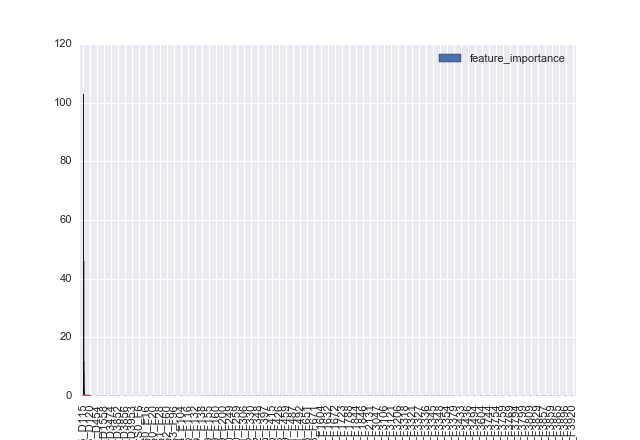

In [29]:
fea_importance_new.plot(kind="bar")

<IPython.core.display.Javascript object>


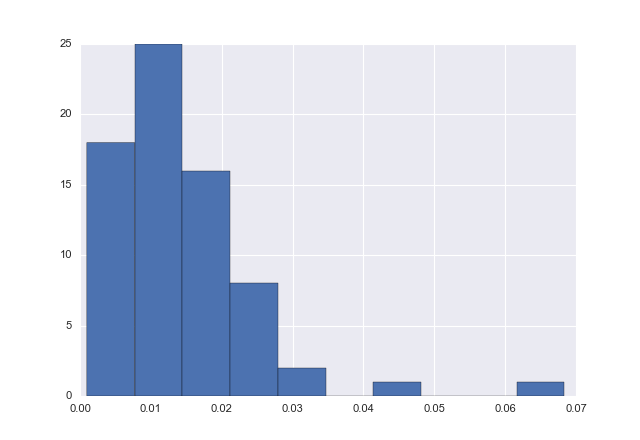

[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24 25 26
 28 29 33 35 36 37 38 39 40 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70]


In [45]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [59]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X = np.concatenate([
    pd.read_csv("../data/train_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - 1156])).values
], axis=1)
y = pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values

In [60]:
y.shape

(1183747, 1)

In [63]:

# xgb_starter = XGBClassifier(
#  learning_rate =0.01,
#  n_estimators=2000,
#  max_depth=10,
#  min_child_weight=1,
#  gamma=0,
#  subsample=1,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27,
#  base_score=0.005)
xgb_params ={
    "learning_rate":0.2,
#  "n_estimators":2000,
    "max_depth":5,
#  "min_child_weight":1,
#  "subsample":0.8,
#  "colsample_bytree":0.8,
#  "objective":'binary:logistic',
#  "nthread":4,
#  "base_score": 'prior',
#  "seed":0,
 "base_score":0.005}

In [64]:
xgtrain = xgb.DMatrix(X, y)
cvresult = xgb.cv(xgb_params, xgtrain, num_boost_round=100, nfold=3,
    metrics='auc', early_stopping_rounds=20, verbose_eval=True)

[0]	train-auc:0.586739+0.00688252	test-auc:0.576487+0.00108218
[1]	train-auc:0.595156+0.00776199	test-auc:0.582794+0.00275485
[2]	train-auc:0.600059+0.00455758	test-auc:0.586099+0.0031236
[3]	train-auc:0.603123+0.00390891	test-auc:0.587322+0.00306424
[4]	train-auc:0.607421+0.00477315	test-auc:0.590159+0.002102
[5]	train-auc:0.610186+0.00452815	test-auc:0.591364+0.00340015
[6]	train-auc:0.611832+0.00449519	test-auc:0.592811+0.00132684
[7]	train-auc:0.613868+0.00539769	test-auc:0.593256+0.000694234
[8]	train-auc:0.61673+0.00504551	test-auc:0.593459+0.00174379
[9]	train-auc:0.619506+0.00597499	test-auc:0.593653+0.00290725
[10]	train-auc:0.621922+0.00395395	test-auc:0.593692+0.00144719
[11]	train-auc:0.624342+0.00203488	test-auc:0.594627+0.00131993
[12]	train-auc:0.626281+0.00282493	test-auc:0.594579+0.00140615
[13]	train-auc:0.628609+0.00353866	test-auc:0.594507+0.00164002
[14]	train-auc:0.630966+0.00333838	test-auc:0.594547+0.00188161
[15]	train-auc:0.632939+0.00336839	test-auc:0.594674+

KeyboardInterrupt: 

In [34]:
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.717
fold 1, ROC AUC: 0.699
fold 2, ROC AUC: 0.695
0.70300131134


In [43]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=20):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    #alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    #dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Print model report:
    #print ("\nModel Report")
    #print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    #print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')

In [44]:
xgtrain = xgb.DMatrix(values, label=y)
xgb_starter = XGBClassifier(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 base_score=0.005)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [42]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

ValueError: Found arrays with inconsistent numbers of samples: [1183747 1183748]

In [36]:
# load test data
X = np.concatenate([
    pd.read_csv("../data/test_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices<1156]+1])).values,
    pd.read_csv("../data/test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices>=1156] +1 - 1156])).values
], axis=1)

In [37]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [38]:
# and submit
sub = pd.read_csv("../data/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")